### Генератор случайных матриц

In [8]:
import numpy as np
from scipy import linalg

def matrix_generate(rows, columns, type_ = "full", eps = 0):
    """
    matrix_generate(rows, columns, type_ = "full")

    Создаёт случайную матрицу выбранного типа.

    Если матрицу нужных размеров создать нельзя должен выдать
    строку f"Error with type {type_} and shape ({rows},{columns})".

    Parameters
    ----------

    rows : int
        Количество строк в создаваемой матрице.
    columns : int
        Количество столбцов в создаваемой матрице.
    type_ : str, optional
        Тип создаваемой матрицы: "full", "upper_triangular", "symmetric" и т.д.
    eps: float, optional
        Дополнительное число, использующееся при генерации для некоторых типов матриц.

    Returns
    -------
    out : ndarray or str
        Выдаёт матрицу нужного типа либо ошибку.

    Notes
    -----
    Поддерживаемые типы матриц:
        "full" - абсолютно случайная матрица
        "diagonal" - диагональная матрица
        "upper_triangular" - верхнетреугольная матрица
        "lower_triangular" - нижнетреугольная матрица
        "symmetric" - симметричная матрица
        "singular" - вырожденная матрица
        "echelon" - матрица ступенчатого вида
        "perturbation" - матрица возмущения

    """

    A = None

    if type_ == "full":
        A = np.random.random(size=(rows, columns))

    elif type_ == "diagonal":
        if rows != columns:
            return f"Error with type {type_} and shape ({rows},{columns})"
        A = np.diag(np.random.random(size=rows))

    elif type_ == "upper_triangular":
        # Для прямоугольных матриц верхнетреугольная форма имеет нули ниже главной диагонали
        A = np.random.random(size=(rows, columns))
        # Создаем маску для нижней треугольной части (ниже главной диагонали)
        mask = np.tri(rows, columns, -1, dtype=bool)
        A[mask] = 0

    elif type_ == "lower_triangular":
        # Для прямоугольных матриц нижнетреугольная форма имеет нули выше главной диагонали
        A = np.random.random(size=(rows, columns))
        # Создаем маску для верхней треугольной части (выше главной диагонали)
        mask = np.tri(rows, columns, -1, dtype=bool)
        A[~mask] = 0

    elif type_ == "symmetric":
        if rows != columns:
            return f"Error with type {type_} and shape ({rows},{columns})"
        # Создаем случайную матрицу и делаем ее симметричной
        random_matrix = np.random.random(size=(rows, columns))
        A = (random_matrix + random_matrix.T) / 2

    elif type_ == "singular":
        # Создаем матрицу с линейно зависимыми строками/столбцами
        if rows > columns:
            # Создаем матрицу ранга меньше rows
            rank = min(rows, columns) - 1
            U = np.random.random((rows, rank))
            V = np.random.random((rank, columns))
            A = U @ V
        else:
            # Создаем матрицу ранга меньше columns
            rank = min(rows, columns) - 1
            U = np.random.random((rows, rank))
            V = np.random.random((rank, columns))
            A = U @ V

    elif type_ == "echelon":
        # Создаем матрицу ступенчатого вида
        A = np.random.random(size=(rows, columns))
        # Приводим к ступенчатому виду
        A = linalg.lu(A)[2]  # U-матрица из LU-разложения
        
    elif type_ == "perturbation":
        # Матрица возмущения с элементами не больше eps по модулю
        if eps <= 0:
            return f"Error: eps must be positive for perturbation matrix"
        A = np.random.uniform(-eps, eps, size=(rows, columns))
        
    else:
        return f"Error: unknown matrix type {type_}"

    return A


def estimate_perturbation_norm(eps, rows, columns, norm_type='fro', num_trials=1000):
    """
    Оценивает верхнюю границу нормы матрицы возмущений.
    
    Parameters
    ----------
    eps : float
        Максимальное значение элементов возмущения
    rows, columns : int
        Размеры матрицы
    norm_type : str
        Тип нормы ('fro', '1', '2', 'inf')
    num_trials : int
        Количество испытаний для оценки
    
    Returns
    -------
    max_norm : float
        Максимальная наблюдаемая норма
    theoretical_bound : float
        Теоретическая верхняя граница
    """
    max_observed = 0
    
    for _ in range(num_trials):
        P = matrix_generate(rows, columns, "perturbation", eps)
        
        if norm_type == 'fro':
            norm = linalg.norm(P, 'fro')
        elif norm_type == '1':
            norm = linalg.norm(P, 1)
        elif norm_type == '2':
            norm = linalg.norm(P, 2)
        elif norm_type == 'inf':
            norm = linalg.norm(P, np.inf)
        else:
            norm = linalg.norm(P, 'fro')
            
        max_observed = max(max_observed, norm)
    
    # Теоретические оценки
    if norm_type == 'fro':
        theoretical = eps * np.sqrt(rows * columns)
    elif norm_type == '1':
        theoretical = eps * columns
    elif norm_type == '2':
        theoretical = eps * np.sqrt(rows * columns)  # Консервативная оценка
    elif norm_type == 'inf':
        theoretical = eps * rows
    else:
        theoretical = eps * np.sqrt(rows * columns)
    
    return max_observed, theoretical


def estimate_singularity_probability(matrix_type, size, num_trials=1000):
    """
    Оценивает вероятность вырожденности матрицы.
    
    Parameters
    ----------
    matrix_type : str
        Тип матрицы
    size : int
        Размер квадратной матрицы
    num_trials : int
        Количество испытаний
    
    Returns
    -------
    probability : float
        Вероятность вырожденности
    """
    singular_count = 0
    
    for _ in range(num_trials):
        A = matrix_generate(size, size, matrix_type)
        if isinstance(A, str):  # Если произошла ошибка
            continue
            
        # Проверяем вырожденность через определитель (для маленьких матриц)
        # или через ранг (для больших)
        if size <= 10:
            det = linalg.det(A)
            if abs(det) < 1e-10:  # Практически вырожденная
                singular_count += 1
        else:
            rank = np.linalg.matrix_rank(A)
            if rank < size:
                singular_count += 1
    
    return singular_count / num_trials

In [9]:
matrix_generate(1, 3)

array([[0.87948174, 0.18145925, 0.75681946]])

In [10]:
matrix_generate(4, 3, type_ = "upper_triangular")

array([[0.56036803, 0.54691133, 0.1421977 ],
       [0.        , 0.12165029, 0.6033096 ],
       [0.        , 0.        , 0.92889813],
       [0.        , 0.        , 0.        ]])

In [11]:
matrix_generate(4, 4, type_ = "symmetric")

array([[0.83798626, 0.84884478, 0.38787684, 0.57481754],
       [0.84884478, 0.4609915 , 0.26934401, 0.30762467],
       [0.38787684, 0.26934401, 0.23801245, 0.44301587],
       [0.57481754, 0.30762467, 0.44301587, 0.69239692]])

In [12]:
matrix_generate(4, 1, type_ = "symmetric")

'Error with type symmetric and shape (4,1)'

### Вычисление матричных норм и числа обусловленности.

In [15]:
from scipy.linalg import eigvals

def vector_norm(x, norm_type='l2'):
    """Вычисляет норму вектора."""
    x = np.asarray(x)
    
    if norm_type == 'l1':
        return np.sum(np.abs(x))
    elif norm_type == 'l2':
        return np.sqrt(np.sum(x**2))
    elif norm_type == 'max':
        return np.max(np.abs(x))
    else:
        raise ValueError("Используйте 'l1', 'l2' или 'max'")

def matrix_norm(A, norm_type='l2'):
    """Вычисляет подчиненную матричную норму."""
    A = np.asarray(A)
    
    if norm_type == 'l1':
        return np.max(np.sum(np.abs(A), axis=0))
    elif norm_type == 'max':
        return np.max(np.sum(np.abs(A), axis=1))
    elif norm_type == 'l2':
        A_T_A = np.dot(A.T, A)
        eigenvalues = np.real(eigvals(A_T_A))
        return np.sqrt(np.max(eigenvalues))
    else:
        raise ValueError("Используйте 'l1', 'l2' или 'max'")

def condition_number(A, norm_type='l2'):
    """Вычисляет число обусловленности матрицы."""
    A = np.asarray(A)
    
    if A.shape[0] != A.shape[1]:
        raise ValueError("Матрица должна быть квадратной")
    
    if np.linalg.det(A) == 0:
        raise ValueError("Матрица вырожденная")
    
    A_inv = np.linalg.inv(A)
    return matrix_norm(A, norm_type) * matrix_norm(A_inv, norm_type)

In [16]:
# Простые тесты для vector_norm
print("=== Тесты vector_norm ===")

# Тест 1: L1 норма
x = np.array([1, -2, 3, -4])
result = vector_norm(x, 'l1')
expected = 10  # |1| + |-2| + |3| + |-4| = 10
print(f"L1 норма [1, -2, 3, -4]: {result} (ожидается: {expected}) - {'ПРОЙДЕН' if result == expected else 'ОШИБКА'}")

# Тест 2: L2 норма
x = np.array([3, 4])
result = vector_norm(x, 'l2')
expected = 5  # sqrt(3² + 4²) = 5
print(f"L2 норма [3, 4]: {result} (ожидается: {expected}) - {'ПРОЙДЕН' if result == expected else 'ОШИБКА'}")

# Тест 3: Максимальная норма
x = np.array([1, -5, 3, -2])
result = vector_norm(x, 'max')
expected = 5  # max(|1|, |-5|, |3|, |-2|) = 5
print(f"Max норма [1, -5, 3, -2]: {result} (ожидается: {expected}) - {'ПРОЙДЕН' if result == expected else 'ОШИБКА'}")

# Тест 4: Нулевой вектор
x = np.array([0, 0, 0])
result = vector_norm(x, 'l1')
expected = 0
print(f"L1 норма нулевого вектора: {result} (ожидается: {expected}) - {'ПРОЙДЕН' if result == expected else 'ОШИБКА'}")

print("\n=== Тесты matrix_norm ===")

# Тест 5: L1 матричная норма
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
result = matrix_norm(A, 'l1')
expected = 18  # max(1+4+7=12, 2+5+8=15, 3+6+9=18) = 18
print(f"L1 матричная норма:\n{result} (ожидается: {expected}) - {'ПРОЙДЕН' if result == expected else 'ОШИБКА'}")

# Тест 6: Максимальная матричная норма
A = np.array([[1, -2],
              [3, -4]])
result = matrix_norm(A, 'max')
expected = 7  # max(1+2=3, 3+4=7) = 7
print(f"Max матричная норма:\n{result} (ожидается: {expected}) - {'ПРОЙДЕН' if result == expected else 'ОШИБКА'}")

print("\n=== Тесты condition_number ===")

# Тест 7: Число обусловленности для единичной матрицы
A = np.eye(2)
result = condition_number(A, 'l2')
expected = 1.0  # cond(I) = 1
print(f"Число обусловленности I: {result:.1f} (ожидается: {expected}) - {'ПРОЙДЕН' if abs(result - expected) < 0.1 else 'ОШИБКА'}")

# Тест 8: Число обусловленности для диагональной матрицы
A = np.array([[2, 0],
              [0, 3]])
result = condition_number(A, 'l2')
print(f"Число обусловленности diag(2,3): {result:.1f} (ожидается: 1.5) - {'ПРОЙДЕН' if abs(result - 1.5) < 0.1 else 'ОШИБКА'}")

=== Тесты vector_norm ===
L1 норма [1, -2, 3, -4]: 10 (ожидается: 10) - ПРОЙДЕН
L2 норма [3, 4]: 5.0 (ожидается: 5) - ПРОЙДЕН
Max норма [1, -5, 3, -2]: 5 (ожидается: 5) - ПРОЙДЕН
L1 норма нулевого вектора: 0 (ожидается: 0) - ПРОЙДЕН

=== Тесты matrix_norm ===
L1 матричная норма:
18 (ожидается: 18) - ПРОЙДЕН
Max матричная норма:
7 (ожидается: 7) - ПРОЙДЕН

=== Тесты condition_number ===
Число обусловленности I: 1.0 (ожидается: 1.0) - ПРОЙДЕН
Число обусловленности diag(2,3): 1.5 (ожидается: 1.5) - ПРОЙДЕН


### Эквивалентность первых двух норм

(np.float64(-1.097562184009572),
 np.float64(1.098802681504311),
 np.float64(-1.0983874537443616),
 np.float64(1.0971716597366075))

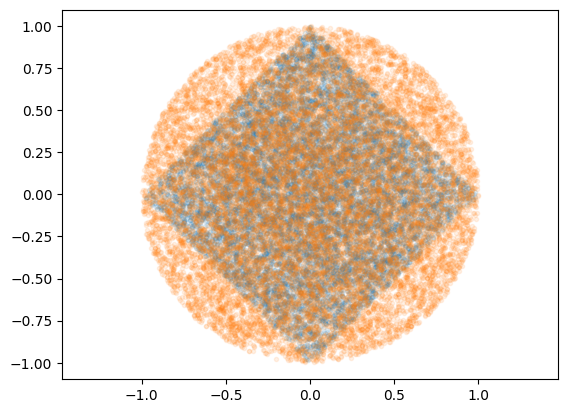

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
p = 1 # Which norm do we use
M = 40000 # Number of sampling points
a = np.random.randn(M, 2)
b = []
for i in range(M):
    if np.linalg.norm(a[i, :], p) <= 1:
        b.append(a[i, :])
b = np.array(b)
plt.plot(b[:, 0], b[:, 1], '.',alpha=0.1)
plt.axis('equal')
p = 2 # Which norm do we use
M = 40000 # Number of sampling points
a = np.random.randn(M, 2)
b = []
for i in range(M):
    if np.linalg.norm(a[i, :], p) <= 1:
        b.append(a[i, :])
b = np.array(b)
plt.plot(b[:, 0], b[:, 1], '.',alpha=0.1)
plt.axis('equal')

$C_{1}||x||_{2}\leq ||x||_{1}\leq C_{2}||x||_{2}$

Из рисунка видно что для $dim = 2$ подходят $C_{1} = \frac{1}{\sqrt{ 2 }},C_{2}=\sqrt{ 2 }$

Обобщая на более высокие размерности получим $C_{1} = \frac{1}{\sqrt{ n }},C_{2}=\sqrt{ n }$

### Евклидова и бесконечная норма

$\lvert \lvert x \rvert  \rvert _{2}\leftrightarrow_{?} \sqrt{ m } \lvert \lvert x \rvert  \rvert _{\infty}$

$\sum _{n=1}^{m}x_{n}^{2}\leftrightarrow_{?} m\cdot(\max_{n} x_{n})^{2}
$

$\sum _{n=1}^{m}x_{n}^{2}\leq \sum _{n=1}^{m}x_{max}^{2}$

Равенство на $x = (1,\dots,1)^{T}$

### Норма Фробениуса

Умножение на унитарную матрицу сохраняет скалярное произведение, а значит и евклидову норму векторов.
Умножение на неё слева матрицы А можно воспринимать как умножение столбцов А как векторов на эту матрицу, слева то же самое,
только со строками.
Так как норма Фробениуса это корень суммы квадратов евклидовых норм её стоблцов или строк, 
которые каждая в отдельности сохраняется, то вся сумма тоже сохраняется, а значит и корень из неё